### Imports

In [130]:
import pandas as pd
import numpy as np
from joblib import dump
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from utils import train_val_set

In [2]:
# Source ext. scripts when saved
%load_ext autoreload
%autoreload 2

### Load data

In [102]:
base_path = '/Users/Neezy/Desktop/ds_projects/m5_forecasting/data/'
sales = pd.read_pickle(base_path + 'sales_sample.pkl')
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales
19,HOBBIES_1_020_CA_1_validation,20,1,HOBBIES,1,CA,1,0
24,HOBBIES_1_025_CA_1_validation,25,1,HOBBIES,1,CA,1,0
36,HOBBIES_1_037_CA_1_validation,37,1,HOBBIES,1,CA,1,0
61,HOBBIES_1_063_CA_1_validation,63,1,HOBBIES,1,CA,1,0
77,HOBBIES_1_080_CA_1_validation,80,1,HOBBIES,1,CA,1,0


### Baseline - Random Forest

#### Feature Engineering

In [4]:
sales_rf = sales.copy()

In [5]:
# Drop unused features
sales_rf_ft = sales_rf.drop('id', axis=1)
sales_rf_ft.head()

,item_id,dept_id,cat_id,store_id,state_id,day,sales
19,20,1,HOBBIES,1,CA,1,0
24,25,1,HOBBIES,1,CA,1,0
36,37,1,HOBBIES,1,CA,1,0
61,63,1,HOBBIES,1,CA,1,0
77,80,1,HOBBIES,1,CA,1,0


In [9]:
# Split categorical variables
cat_vars = sales_rf_ft[['dept_id', 'cat_id', 'store_id', 'state_id']]
other_vars = sales_rf_ft[['day', 'sales']]

# One hot encoding
one_hot = OneHotEncoder()
cat_vars_oh = one_hot.fit_transform(cat_vars).toarray()
cat_vars_oh = pd.DataFrame(
    cat_vars_oh, columns=one_hot.get_feature_names(cat_vars.columns))
cat_vars_oh.index = cat_vars.index

# Append Y again
sales_rf_ft_oh = pd.concat([cat_vars_oh, other_vars], axis=1)
sales_rf_ft_oh.head()

,dept_id_2,dept_id_3,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_2,store_id_3,store_id_4,state_id_TX,state_id_WI,day,sales
19,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
24,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
36,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
61,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
77,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [ ]:
# Save one-hot encoder
dump(one_hot, '../models/one_hot_encoder.joblib') 

#### Cross-Validation

--------------------
Iteration 1
Training set from day 1000 to 1884 with 1327500 observations.
Validation set from day 1885 to 1913 with 43500 observations.
Error: 1.71
AxesSubplot(0.125,0.125;0.775x0.755)
--------------------
Iteration 31
Training set from day 970 to 1854 with 1327500 observations.
Validation set from day 1855 to 1883 with 43500 observations.
Error: 1.46
AxesSubplot(0.125,0.125;0.775x0.755)
--------------------
Iteration 61
Training set from day 940 to 1824 with 1327500 observations.
Validation set from day 1825 to 1853 with 43500 observations.
Error: 1.44
AxesSubplot(0.125,0.125;0.775x0.755)
--------------------
Iteration 91
Training set from day 910 to 1794 with 1327500 observations.
Validation set from day 1795 to 1823 with 43500 observations.
Error: 1.40
AxesSubplot(0.125,0.125;0.775x0.755)
Mean MAE: 1.503


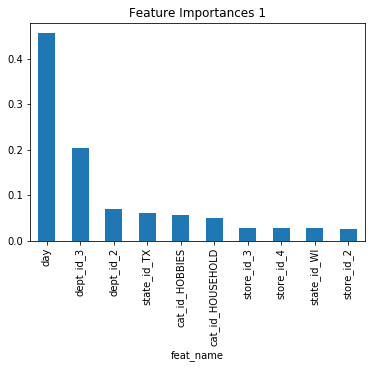

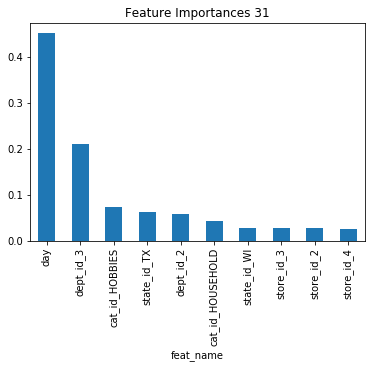

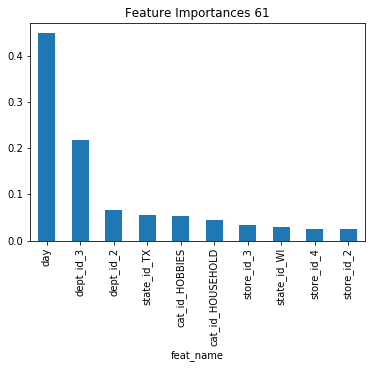

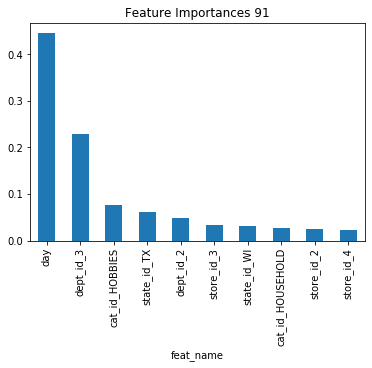

In [42]:
mae_list = []
for n_iter in range(0, 91, 30):
    print(20*'-')
    print(f'Iteration {n_iter+1}')
    # Create split
    train_x, train_y, val_x, val_y = train_val_set(
        sales_rf_ft_oh, 'day', 28, n_iter, 1000, 'sales')
    # Train model
    rf = RandomForestRegressor(
        n_estimators=100, n_jobs=-1, random_state=42).fit(train_x, train_y)
    # Predict
    pred_y = rf.predict(val_x)
    # Evaluate
    mae = mean_absolute_error(val_y, pred_y)
    print(f'Error: {mae:.2f}')
    mae_list.append(mae)
# Mean error
mean_mae = np.mean(mae_list)
print(f'Mean MAE: {mean_mae:.3f}')

### Train Final Model

In [134]:
train_x = sales_rf_ft_oh.drop('sales', axis=1)
train_y = sales_rf_ft_oh['sales']
print(train_x.shape, train_y.shape)

(2869500, 10) (2869500,)


In [135]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(train_x, train_y)

In [136]:
# Save rf model
dump(rf, '../models/rf_v_1_0.joblib') 

['../models/rf_v_1_0.joblib']